In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib widget
log_folder = 'runs'

from matplotlib import rc
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('axes', titlesize=16)
rc('axes', labelsize=16)
rc('axes', axisbelow=False)
rc('lines',linewidth=1.5)
# lines.markersize : 10
rc('xtick', labelsize=16)
rc('xtick.major',size=10)
rc('xtick.minor',size=5)
rc('xtick',direction='in')
rc('ytick', labelsize=16)
rc('ytick.major',size=10)
rc('ytick.minor',size=5)
rc('ytick',direction='in')
# rc('legend',fontsize='large')

/home/ohahn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations, get_xi_from_P, power_Kaiser

In [3]:
## Cosmological Parameters

## Cosmological Parameters
Tcmb    = 2.7255
YHe     = 0.248
Omegam  = 0.3099
Omegab  = 0.0488911
# OmegaDE = 1.0-Omegam
w_DE_0  = -0.99
w_DE_a  = 0.00
cs2_DE  = 0.99
mnu     = 0.06  #eV
Neff    = 3.046 # -1 if massive neutrino present
Tnu     = (4/11)**(1/3) #0.71611 # Tncdm of CLASS
Neff    = 3.046 # -1 if massive neutrino present
N_nu_mass = 1
N_nu_rel = Neff - N_nu_mass * (Tnu/((4/11)**(1/3)))**4
H0      = 67.742
A_s     = 2.1064e-09
n_s     = 0.96822

b       = 2.0   # bias
sigmaz0  = 0.03  # redshift error


# list of parameters with respect to which we take derivatives
fieldnames = ['H_0', '\\Omega_m', '\\Omega_b', 'N_{eff}', 'm_{\\nu}', 'T_{CMB}', 'Y_{He}', 'A_s', 'n_s', 'w_0', '(1+w_a)', 'b_1',  '\\sigma_z0',  'c_a^2']
fiducial_cosmo_param = jnp.array([H0, Omegam, Omegab, N_nu_rel, mnu, Tcmb, YHe, A_s, n_s,  w_DE_0, 1+w_DE_a,  b, sigmaz0,  cs2_DE])

# modes to sample
nmodes = 512
nmu    = 512
kmin   = 1e-4
kmax   = 1e+1
aexp   = 1.0 # scale factor at which to evaluate, can also be a jax.array



In [4]:
def Pkmu_of_cosmo( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    param = {}
    param['Omegam'] = args[1]
    param['Omegab'] = args[2]
    param['OmegaDE'] = 1-args[1]
    param['Omegak'] = 0.0
    param['A_s'] = args[7]
    param['n_s'] = args[8]
    param['H0'] = args[0]
    param['Tcmb'] = args[5]
    param['YHe'] = args[6]
    param['Neff'] = args[3]
    param['Nmnu'] = N_nu_mass
    param['mnu'] = args[4]
    param['w_DE_0'] = args[9]
    param['w_DE_a'] = args[10]-1
    param['cs2_DE'] = args[13]

    param['k_p']  = 0.05

    b = args[11]
    sigmaz0 = args[12]

    h = param['H0'] / 100.

    ## Compute Background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')

    # Compute Perturbations
    # lmaxg  = 12
    # lmaxgp = 12
    # lmaxr  = 17
    # lmaxnu = 17
    # nqmax  = 15

    rtol   = 1e-4
    atol   = 1e-4

    aexp_out = jnp.atleast_1d(aexp)
    kmodes   = jnp.geomspace(kmin, kmax, nmodes)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out,
                                    #   lmaxg=lmaxg, lmaxgp=lmaxgp, lmaxr=lmaxr, lmaxnu=lmaxnu, nqmax=nqmax,
                                       rtol=rtol, atol=atol )

    Pkmu, mu, theta = power_Kaiser( y=y[:,-1,:], kmodes=kmodes, b=b, aexp=aexp_out[-1], sigma_z0 = sigmaz0, nmu=nmu, param=param )


    return Pkmu, mu, theta, kmodes 


In [5]:
def Pk_of_cosmo( args ):
    """ Compute the matter (b+c) power spectrum for a given set of cosmological parameters"""
    param = {}
    param['Omegam'] = args[1]
    param['Omegab'] = args[2]
    param['OmegaDE'] = 1-args[1]
    param['Omegak'] = 0.0
    param['A_s'] = args[7]
    param['n_s'] = args[8]
    param['H0'] = args[0]
    param['Tcmb'] = args[5]
    param['YHe'] = args[6]
    param['Neff'] = args[3]
    param['Nmnu'] = N_nu_mass
    param['mnu'] = args[4]
    param['w_DE_0'] = args[9]
    param['w_DE_a'] = args[12]-1
    param['cs2_DE'] = args[13]

    param['k_p']  = 0.05

    b = args[10]
    sigmaz = args[11]

    ## Compute Background evolution
    param = evolve_background(param=param, thermo_module='RECFAST')

    # Compute Perturbations
    # lmaxg  = 12
    # lmaxgp = 12
    # lmaxr  = 17
    # lmaxnu = 17
    # nqmax  = 15

    rtol   = 1e-4
    atol   = 1e-4

    aexp_out = jnp.atleast_1d(aexp)
    kmodes   = jnp.geomspace(kmin, kmax, nmodes)

    y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out,
                                    #   lmaxg=lmaxg, lmaxgp=lmaxgp, lmaxr=lmaxr, lmaxnu=lmaxnu, nqmax=nqmax,
                                       rtol=rtol, atol=atol )

    # Pkmu, mu, theta = power_Kaiser( y=y[:,-1,:], kmodes=kmodes, b=b, aexp=aexp_out[-1], sigma_z = sigmaz, nmu=nmu, param=param )


    return y, kmodes


In [6]:
# compute the fiducial power spectrum
Pkmu, mu, theta, kmodes = Pkmu_of_cosmo( fiducial_cosmo_param )


In [7]:
# compute the derivative of the power spectrum with respect to the cosmological parameters, this takes some time... (ca. 2min, incl. compilation on RTX3090)
dPkmu_dcosmo = jax.jacfwd( Pkmu_of_cosmo )
dPkmu,_,_,_ = dPkmu_dcosmo( fiducial_cosmo_param )

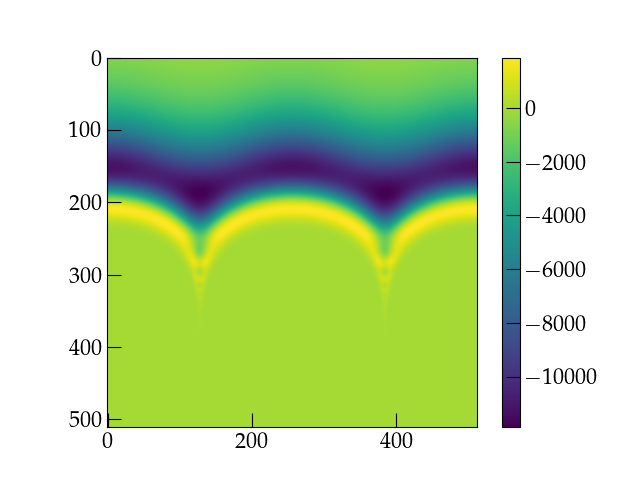

In [8]:
fig,ax = plt.subplots()
# ax.imshow(dPkmu[...,1])
# ii = Pkmu < 1e-10
myim = dPkmu[...,0]#/Pkmu
# myim = myim.at[ ii].set( 0.0 )
im=ax.imshow(myim)#,vmin=-0.01,vmax=0.01)
plt.colorbar(im)


In [9]:
dPkmu.shape

(512, 512, 14)

Text(0, 0.5, '$\\log_{10} k$')

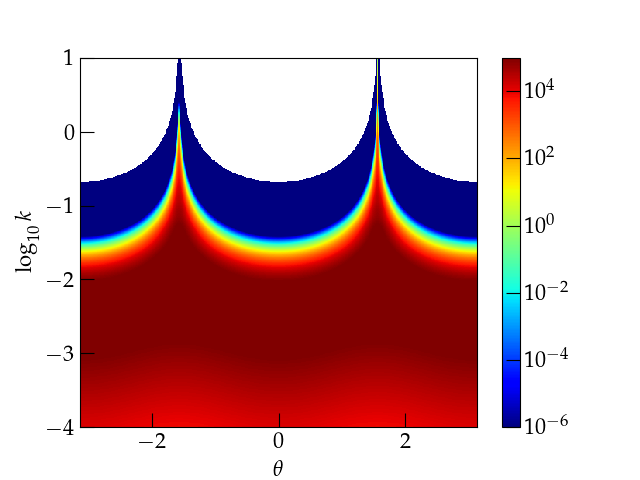

In [10]:

# create a map of the powerspectrum
fig, ax = plt.subplots()

im = ax.pcolor( theta, jnp.log10(kmodes), Pkmu, cmap='jet', shading='auto', norm=colors.LogNorm(vmin=1e-6, vmax=1e+5) )
plt.colorbar(im, ax=ax)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\log_{10} k$')

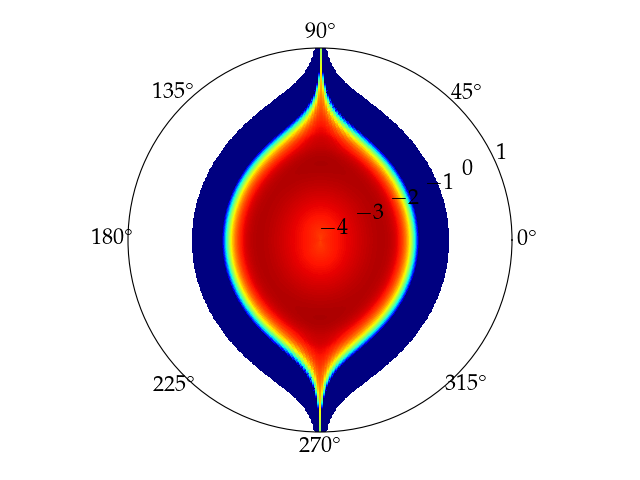

In [11]:
# create a polar map
fig, ax = plt.subplots()
ax.set_axis_off()
ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
ax.grid(False)
ax.pcolormesh( theta, jnp.log10(kmodes), Pkmu,edgecolors='face', norm=colors.LogNorm(vmin=1e-7, vmax=1e6),
                   cmap='jet', shading='auto')


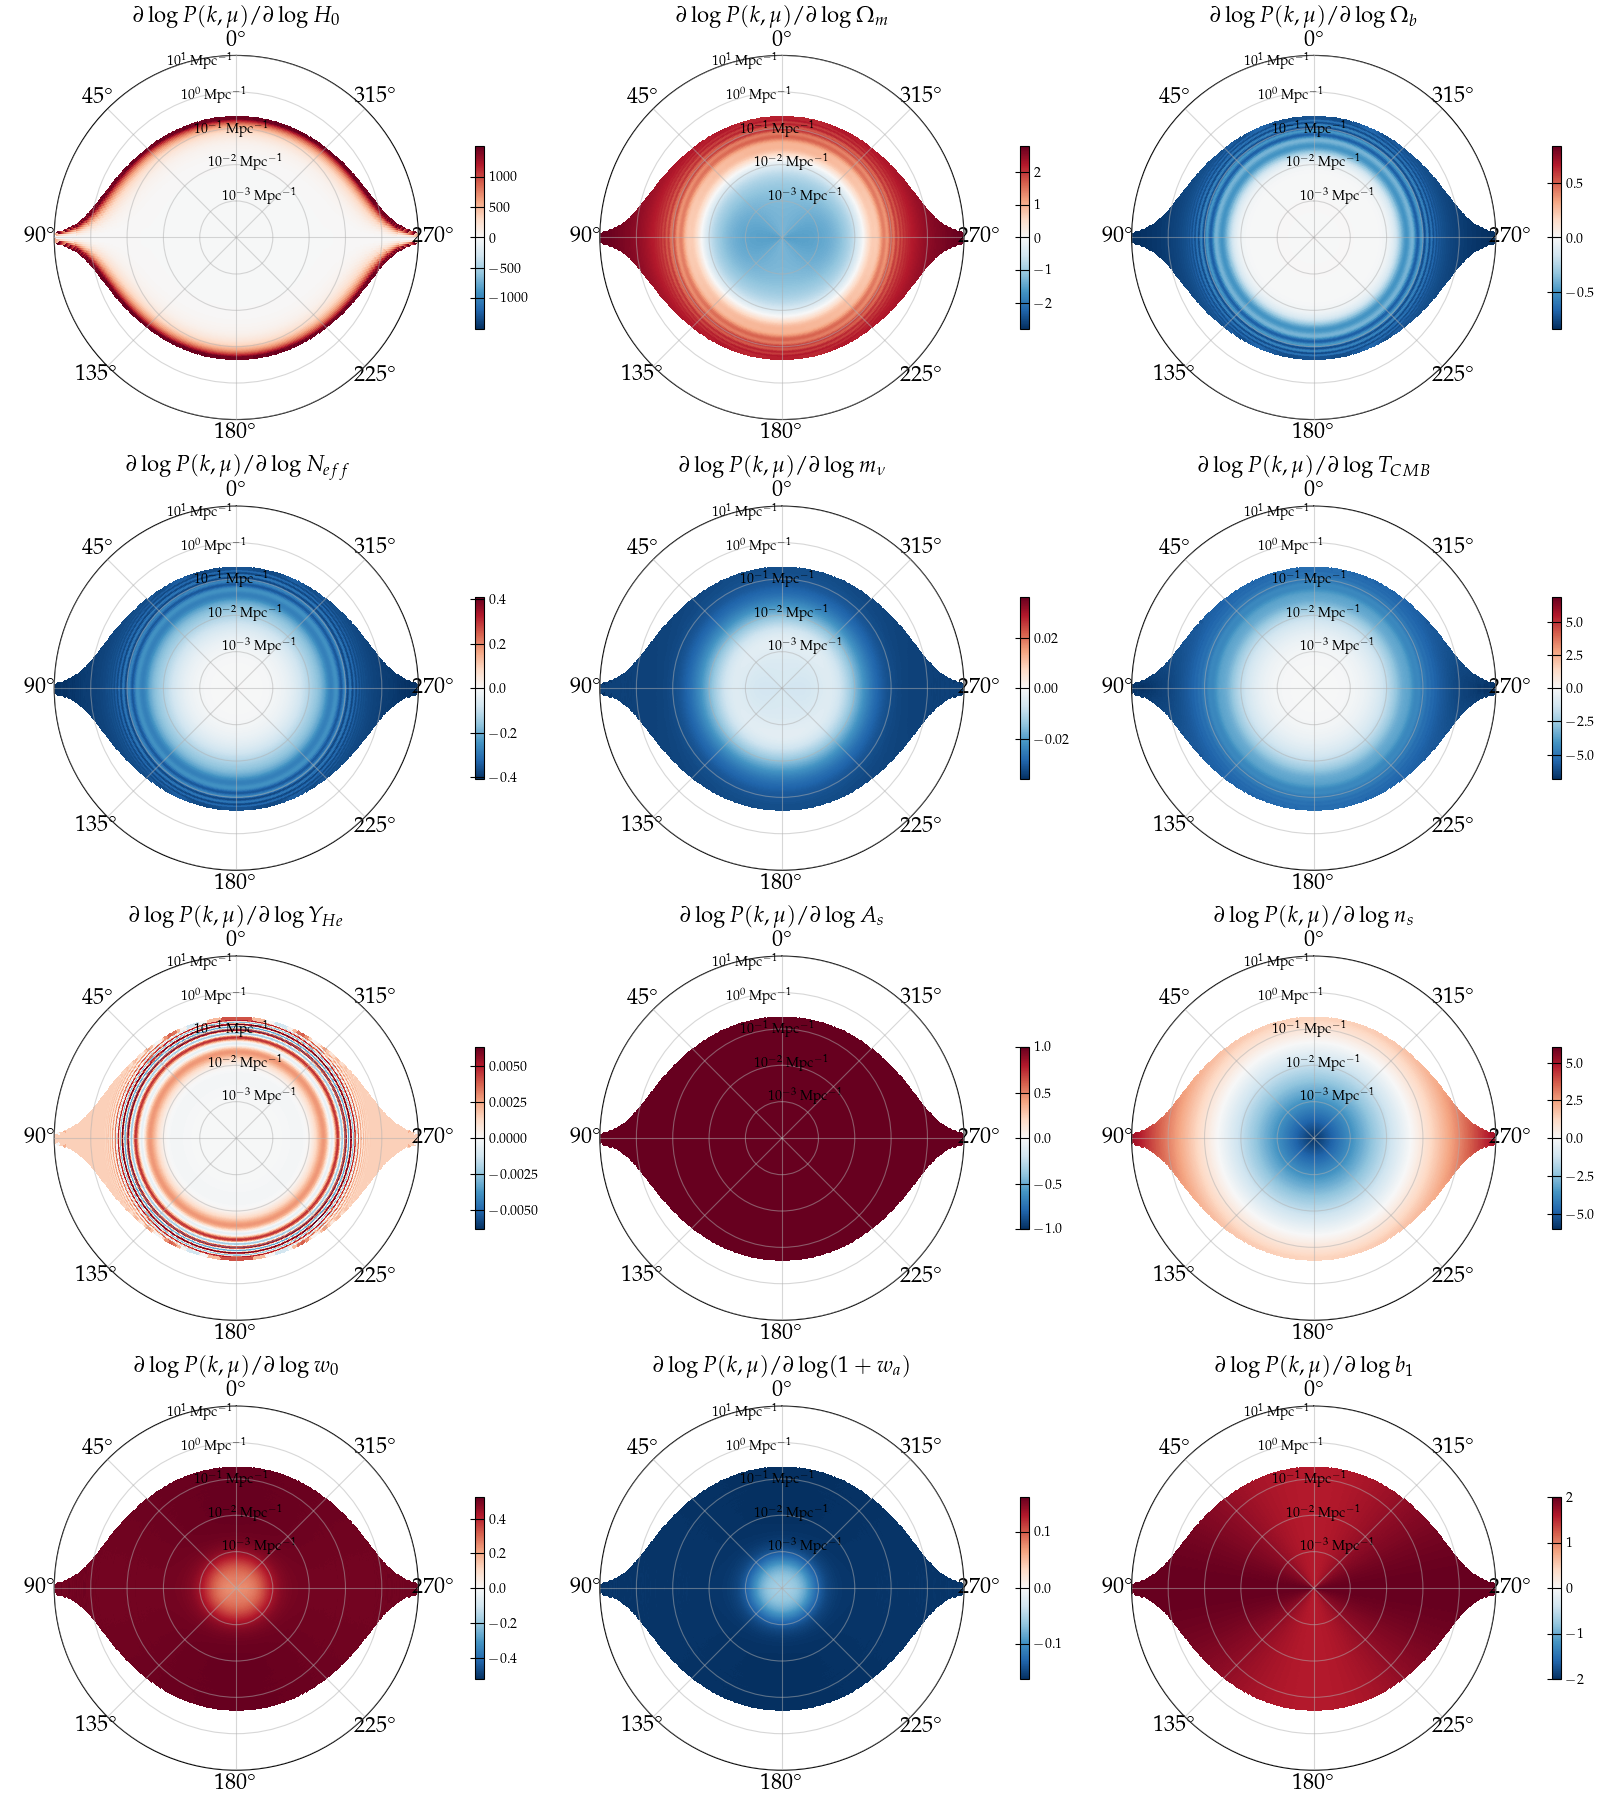

In [12]:

# create a polar map of the derivative of the power spectrum with respect to the cosmological parameters
# fig, ax = plt.subplots(layout='constrained')
fig,axs = plt.subplots(4,3,sharex=True,figsize=(16,18),layout='constrained',subplot_kw={'projection': 'polar'})

for i,ff in enumerate(fieldnames[:12]):
    iy = i%3
    ix = i//3
    dlogPkmu = dPkmu[...,i]/Pkmu

    ax = axs[ix,iy]
    ax.grid(False)
    ax.pcolormesh( theta, jnp.log10(kmodes), dPkmu[...,i]/Pkmu, edgecolors='face',
                      cmap='RdBu_r', shading='auto', rasterized=True)
    
    dlogPkmu = fiducial_cosmo_param[i] * dPkmu[...,i]/Pkmu
    cc = np.max(np.abs(dlogPkmu)[~np.isnan(np.abs(dlogPkmu))])
    im = ax.pcolormesh( theta, jnp.log10(kmodes), dlogPkmu, edgecolors='face',
                    cmap='RdBu_r', shading='auto', rasterized=True, vmin=-cc,vmax=cc)

    cbar = plt.colorbar(im, ax=ax, shrink=0.5)
    cbar.ax.tick_params(labelsize=10)


    ax.set_theta_zero_location('N')
    ax.grid(True,alpha=0.5)
    ax.set_rticks([-3,-2,-1,0,1])
    ax.set_yticklabels(['$10^{-3}\\;{\\rm Mpc}^{-1}$','$10^{-2}\\;{\\rm Mpc}^{-1}$','$10^{-1}\\;{\\rm Mpc}^{-1}$','$10^{0}\\;{\\rm Mpc}^{-1}$','$10^{1}\\;{\\rm Mpc}^{-1}$'],size=10)
    ax.set_title(f'$\partial \log P(k,\mu)/\partial \log {fieldnames[i]}$')

plt.savefig('dlogPkmu_dcosmo.pdf',bbox_inches='tight', dpi=300)
# plt.savefig('dlogPkmu_dcosmo_dpi300.png',bbox_inches='tight', dpi=300)


In [11]:
#### To solve integral over mu, use jnp.trapz over mu dimension of Pkmu
ivar = 1
jvar = 2

Veff = jnp.ones((nmodes,nmu)) # effective volume, to implement
# product of derivatives
dPkmu_dcosmo_prod = dPkmu[...,ivar]*dPkmu[...,jvar] * Veff

# integrate over mu
dPk_dcosmo = jnp.trapz( dPkmu_dcosmo_prod, x=mu, axis=-1 )
# integrate over k
F_ij = 1/(8*jnp.pi**2) * jnp.trapz( dPk_dcosmo * kmodes**2, x=kmodes, axis=-1 )

print(F_ij)

AttributeError: module 'jax.numpy' has no attribute 'trapz'

Text(0.5, 1.0, '$\\partial \\log P(k,\\mu)/\\partial c_a^2$')

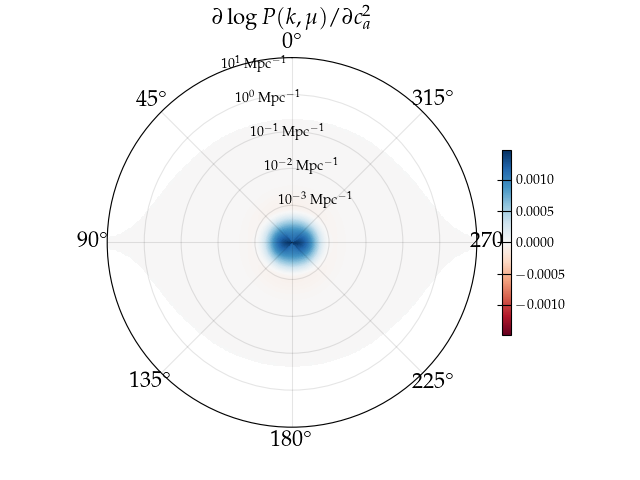

In [ ]:
# create a polar map of the derivative of the power spectrum with respect to the cosmological parameters
# fig, ax = plt.subplots(layout='constrained')

# 0 : 1e-4 , 1e4, negative
# 1 : -3, 3
# 2 : -1, 1 
# 3 : -1/2, 1/2

fig,ax = plt.subplots(subplot_kw={'projection': 'polar'})
ivar = 13


ax.grid(False)
dlogPkmu = fiducial_cosmo_param[ivar] * dPkmu[...,ivar]/Pkmu
cc = np.max(np.abs(dlogPkmu)[~np.isnan(np.abs(dlogPkmu))])
im = ax.pcolormesh( theta, jnp.log10(kmodes), dlogPkmu, edgecolors='face',
                  cmap='RdBu', shading='auto', rasterized=True, vmin=-cc,vmax=cc)#, vmin=-1, vmax=1 )#, vmin=-20000, vmax=+20000)#, norm=colors.LogNorm(vmin=1e-4, vmax=1e+4) )#vmin=-100000, vmax=0)

cbar = plt.colorbar(im, ax=ax, shrink=0.5)
cbar.ax.tick_params(labelsize=10)

ax.set_theta_zero_location('N')
ax.grid(True,alpha=0.1,c='k')
ax.set_rticks([-3,-2,-1,0,1])
ax.set_yticklabels(['$10^{-3}\\;{\\rm Mpc}^{-1}$','$10^{-2}\\;{\\rm Mpc}^{-1}$','$10^{-1}\\;{\\rm Mpc}^{-1}$','$10^{0}\\;{\\rm Mpc}^{-1}$','$10^{1}\\;{\\rm Mpc}^{-1}$'],size=10)
ax.set_title(f'$\partial \log P(k,\mu)/\partial {fieldnames[ivar]}$')